# LLG Auction in Imperfect Correlation Bernoulli weights model with $\gamma=0$

## Imports

In [1]:
import os
import sys
root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)
import time
from timeit import default_timer as timer
from functools import partial

import torch
import torch.nn as nn
import torch.nn.utils as ut
from torch.optim.optimizer import Optimizer, required

from bnelearn.strategy import NeuralNetStrategy, ClosureStrategy
from bnelearn.bidder import Bidder
from bnelearn.mechanism import LLGAuction
from bnelearn.learner import ESPGLearner
from bnelearn.environment import AuctionEnvironment

from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt

# set up matplotlib
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display
plt.rcParams['figure.figsize'] = [10, 7]
    
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'

# Use specific cuda gpu if desired (i.e. for running multiple experiments in parallel)
specific_gpu = 4
if cuda and specific_gpu:
    torch.cuda.set_device(specific_gpu)

print(device)
if cuda: print(torch.cuda.current_device())

cuda
4


## Settings


In [2]:
# log in notebook folder
# alternative for shared access to experiments:
#log_root = os.path.abspath('/srv/bnelearn/experiments')
log_root = os.path.abspath('.')
run_comment = None
save_figure_data_to_disc = False
save_figure_to_disc = False

## Experiment setup
n_players = 3
n_items = 1

allocation_rule = 'proxy' # vcg, proxy
gamma = 0


# valuation distribution

u_hi_local = 1.0
u_hi_global = 2.0

u_lo = 0

u_his = [u_hi_local, u_hi_local, u_hi_global]

def strat_to_bidder(strategy, batch_size, player_position):
    return Bidder.uniform(u_lo, u_his[player_position], strategy, player_position=player_position, batch_size = batch_size)

## Environment settings
#training batch size
batch_size = 2**15
eval_batch_size = 2**18
epoch = 2000

# strategy model architecture
input_length = 1
hidden_nodes = [5, 5]
hidden_activations = [nn.SELU(), nn.SELU()]


learner_hyperparams = {
    'population_size': 128,
    'sigma': 1.,
    'scale_sigma_by_model_size': True
}

### Optimizer hyperparams
# SGD standards
    #'lr': 1e-3,
    #'momentum': 0.7
# Adam standards:
    # 'lr': 1e-3
    # 'betas': (0.9, 0.999), #coefficients for running avgs of grad and square grad
    # 'eps': 1e-8 , # added to denominator for numeric stability
    # 'weight_decay': 0, #L2-decay
    # 'amsgrad': False #whether to use amsgrad-variant
optimizer_type = torch.optim.SGD
optimizer_hyperparams ={    
    'lr': 1e-3,
    'momentum': 0.9
}

# plot and log training options
plot_epoch = 10
plot_points = min(100, batch_size)

#plot_xmin = u_lo
#plot_xmax = u1_hi
#plot_ymin = 0
#plot_ymax = 15

## Setting up the Environment

For equilibria see working document for now


In [8]:
# for evaluation

def optimal_bid(valuation: torch.Tensor or np.ndarray or float, player_position: int) -> torch.Tensor:
    if not isinstance(valuation, torch.Tensor):
        valuation = torch.tensor(valuation)
    
    # all core-selecting rules are strategy proof for global player:
    if player_position == 2:
        return valuation
    
    ## local bidders:
    
    if allocation_rule == 'vcg':        
        return valuation
    if allocation_rule == 'proxy':
        bid_if_positive = 1 + torch.log(valuation * (1.0-gamma) + gamma)/(1.0-gamma)
        return torch.max( torch.zeros_like(valuation), bid_if_positive)        
    
    raise ValueError('optimal bid not implemented for other rules')

def setup_custom_scalar_plots(writer):    
    ## define layout first, then call add_custom_scalars once
    layout = {'eval':
        {
            #'Loss vs BNE relative': ['Multiline',
            #                         ['eval_players/p{}_epsilon_relative'.format(i) for i in range(n_players)]]
            #'How to make a margin chart': ['Margin', ['tag_mean', 'tag_min', 'tag_max']]
        }
    }    
    writer.add_custom_scalars(layout) 

def log_once(writer, e):
    """Everything that should be logged only once on initialization."""
    for i in range(n_players):
        writer.add_scalar('debug_players/p{}_model_parameters'.format(i), n_parameters[i], e)
    writer.add_scalar('debug/model_parameters', sum(n_parameters), e)
    writer.add_scalar('debug/eval_batch_size', eval_batch_size, e)
    for a in agents:
        writer.add_text('hyperparams/neural_net_spec', str(a.strategy), 0)    
    #writer.add_scalar('debug/eval_batch_size', eval_batch_size, e)
    writer.add_graph(model_l1, env.agents[0].valuations)    

def log_hyperparams(writer, e):
#     writer.add_scalar('hyperparams/batch_size', batch_size, e)
#     writer.add_scalar('hyperparams/batch_size', batch_size, e)
#     writer.add_scalar('hyperparams/learning_rate', learning_rate, e)
#     writer.add_scalar('hyperparams/momentum', momentum, e)
#     writer.add_scalar('hyperparams/sigma', sigma, e)
#     writer.add_scalar('hyperparams/n_perturbations', n_perturbations, e)
    pass
        
def log_metrics(writer, u, u_vs_bne, e):
    """log scalar for each player. Tensor should be of shape n_players"""
    epsilons_rel = eps_rel(u_vs_bne)
    epsilons_abs = eps_abs(u_vs_bne)
    
    # redundant logging of utlities for multiline
    for i in range(n_players):
        ## Note: multiline chart capture all tags that match the given beginning of the tag_name,
        ## i.e. eval/utility will match all of  eval/utility, eval/utility_sp and eval/utlity_vs_bne
        ## thus self play utility should be named utility_sp to be able to capture it by itself later.
        writer.add_scalar('eval_players/p{}_utility_sp'.format(i), u[i], e)
        writer.add_scalar('eval_players/p{}_utility_vs_bne'.format(i), u_vs_bne[i], e)
        writer.add_scalar('eval_players/p{}_epsilon_absolute'.format(i), epsilons_abs[i], e)
        writer.add_scalar('eval_players/p{}_epsilon_relative'.format(i), epsilons_rel[i], e)
    
    writer.add_scalar('eval/epsilon_relative', epsilons_rel.mean(),e)
    writer.add_scalar('debug/epsilon_absolute', epsilons_abs.mean(),e)

vl1_opt = np.linspace(u_lo, u_hi_local, 25)
bl1_opt = optimal_bid(vl1_opt, 0).numpy()
vl2_opt = np.linspace(u_lo, u_hi_local, 25)
bl2_opt = optimal_bid(vl2_opt, 0).numpy()
vg_opt = np.linspace(u_lo, u_hi_global, 50)
bg_opt = optimal_bid(vg_opt, 2).numpy() 

plot_xmin = 0
plot_xmax = 2
plot_ymin = 0
plot_ymax = 3

def plot_bid_function(fig, vl1,bl1, vl2, bl2, vg, bg, writer=None, e=None,
                      plot_points=plot_points,
                      save_vectors_to_disc=save_figure_data_to_disc,
                      save_png_to_disc = False):
    #plot_points = min(plot_points, len(v1), len(v2))
    
    # subsample points and plot    
    vl1 = vl1.detach().cpu().numpy()[:plot_points]
    bl1 = bl1.detach().cpu().numpy()[:plot_points]
    vl2 = vl2.detach().cpu().numpy()[:plot_points]
    bl2 = bl2.detach().cpu().numpy()[:plot_points]
    vg = vg.detach().cpu().numpy()[:plot_points]
    bg = bg.detach().cpu().numpy()[:plot_points]
    

        
    fig = plt.gcf()
    plt.cla()
    plt.xlim(plot_xmin, plot_xmax)
    plt.ylim(plot_ymin, plot_ymax)
    plt.xlabel('valuation')
    plt.ylabel('bid')
    plt.text(plot_xmin + 1, plot_ymax - 1, 'iteration {}'.format(e))
    plt.plot(vl1,bl1, 'bo', vl1_opt, bl1_opt, 'b--', vl2,bl2, 'go', vl2_opt, bl2_opt, 'g--', vg,bg, 'ro', vg_opt,bg_opt, 'r--')
    if is_ipython:
        display.clear_output(wait=True)
    display.display(fig)
    #plt.show()
    if save_png_to_disc:
        plt.savefig(os.path.join(logdir, 'png', run_name + f'_{e:05}.png'))
    if writer:
        writer.add_figure('eval/bid_function', fig, e)  

Initialize the model.
We'll ensure the initialization provides positive outputs on the domain we are interested in, as otherwise we can't learn.

In [9]:
# initialize models
model_l1 = NeuralNetStrategy(input_length,                            
                            hidden_nodes = hidden_nodes,
                            hidden_activations = hidden_activations,
                            ensure_positive_output = torch.tensor([float(u_hi_local)])
                            ).to(device)   

model_l2 = NeuralNetStrategy(input_length,
                            hidden_nodes = hidden_nodes,
                            hidden_activations = hidden_activations,
                            ensure_positive_output = torch.tensor([float(u_hi_local)])
                            ).to(device)

# global player
model_g = NeuralNetStrategy(input_length,
                            hidden_nodes = hidden_nodes,
                            hidden_activations = hidden_activations,
                            ensure_positive_output = torch.tensor([float(u_hi_global)])
                            ).to(device)

bidder_l1 = strat_to_bidder(model_l1, batch_size, player_position=0)
bidder_l2 = strat_to_bidder(model_l2, batch_size, player_position=1)
bidder_g  = strat_to_bidder(model_g,  batch_size, player_position=2)

agents = [bidder_l1, bidder_l2, bidder_g]

n_parameters = [sum([p.numel() for p in model.parameters()]) for model in [b.strategy for b in agents]]



mechanism = LLGAuction(rule = allocation_rule, cuda = cuda)
env = AuctionEnvironment(mechanism,
                  agents = agents,
                  batch_size = batch_size,
                  n_players =n_players,
                  strategy_to_player_closure = strat_to_bidder
                 )
learner_l1 = ESPGLearner(
    model = model_l1,
    environment = env,
    hyperparams = learner_hyperparams,
    optimizer_type = optimizer_type,
    optimizer_hyperparams = optimizer_hyperparams,
    strat_to_player_kwargs={"player_position":0})

learner_l2 = ESPGLearner(
    model = model_l2,
    environment = env,
    hyperparams = learner_hyperparams,
    optimizer_type = optimizer_type,
    optimizer_hyperparams = optimizer_hyperparams,
    strat_to_player_kwargs={"player_position":1})

learner_g = ESPGLearner(
    model = model_g,
    environment = env,
    hyperparams = learner_hyperparams,
    optimizer_type = optimizer_type,
    optimizer_hyperparams = optimizer_hyperparams,
    strat_to_player_kwargs={"player_position":2})



print(model_l1)
print('Total parameters: ' + str(n_parameters))

NeuralNetStrategy(
  (layers): ModuleDict(
    (fc_0): Linear(in_features=1, out_features=5, bias=True)
    (activation_0): SELU()
    (fc_1): Linear(in_features=5, out_features=5, bias=True)
    (activation_1): SELU()
    (fc_out): Linear(in_features=5, out_features=1, bias=True)
    (activation_out): ReLU()
  )
)
Total parameters: [46, 46, 46]


## Set up equilibrium-environment

In [10]:
bne_strategies = [
    ClosureStrategy(partial(optimal_bid, player_position=i))
    for i in range(n_players)
]

bne_env = AuctionEnvironment(
    mechanism,
    agents = [strat_to_bidder(bne_strategies[i], player_position=i, batch_size=eval_batch_size)
              for i in range(n_players)],
    n_players = n_players,
    batch_size = eval_batch_size,
    strategy_to_player_closure = strat_to_bidder
)

#print("Utility in BNE (analytical): \t{:.5f}".format(bne_utility))
bne_utilities_sampled = torch.tensor([bne_env.get_reward(a, draw_valuations = True) for a in bne_env.agents])
print(('Utilities in BNE (sampled):'+ '\t{:.5f}'*n_players + '.').format(*bne_utilities_sampled))


eps_abs = lambda us: bne_utilities_sampled - us
eps_rel = lambda us: 1- us/bne_utilities_sampled

utilities_vs_bne = torch.tensor([bne_env.get_strategy_reward(a.strategy, player_position=i) for i,a in enumerate(env.agents)])
print(('Model utility vs BNE: \t'+'\t{:.5f}'*n_players).format(*utilities_vs_bne))

utilities_learning_env = torch.tensor([env.get_strategy_reward(a.strategy, player_position=i, draw_valuations = True) for i,a in enumerate(env.agents)])
print(('Model utility in learning env:'+'\t{:.5f}'*n_players).format(*utilities_learning_env))

Utilities in BNE (sampled):	0.11776	0.14999	0.46262.
Model utility vs BNE: 		0.05959	0.09524	0.27745
Model utility in learning env:	0.00000	0.00000	0.95455


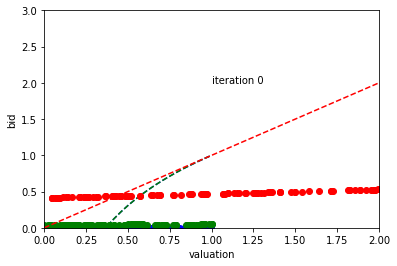

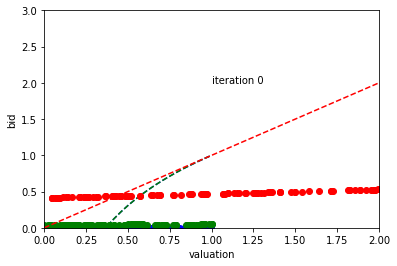

In [11]:
bidder_l1.draw_valuations_()
v_l1 = bidder_l1.valuations
b_l1 = bidder_l1.get_action()

bidder_l2.draw_valuations_()
v_l2 = bidder_l2.valuations
b_l2 = bidder_l2.get_action()

bidder_g.draw_valuations_()
v_g = bidder_g.valuations
b_g = bidder_g.get_action()

fig = plt.figure()
plot_bid_function(fig, v_l1, b_l1, v_l2, b_l2, v_g, b_g, writer=None,e=0) 

## Training

In [12]:
print(log_root)

/home/heidekrueger/bnelearn/notebooks


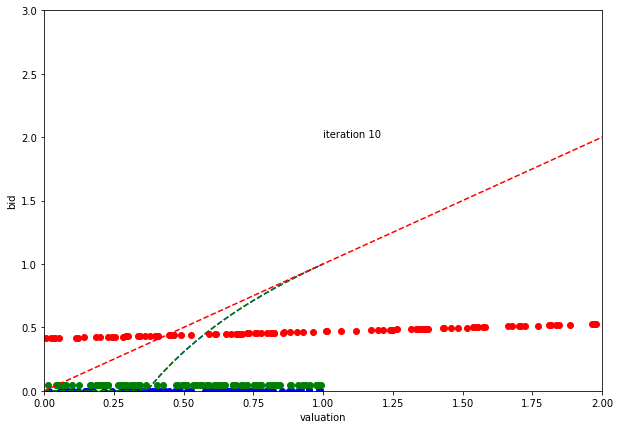

In [ ]:
if os.name == 'nt': raise ValueError('The run_name may not contain : on Windows! (change datetime format to fix this)') 
run_name = time.strftime('%Y-%m-%d %a %H:%M')
if run_comment:
    run_name = run_name + ' - ' + str(run_comment)
logdir = os.path.join(log_root, 'llg', str(allocation_rule), 'gamma_' + str(gamma), run_name)
print(logdir)
os.makedirs(logdir, exist_ok=False)
if save_figure_to_disc:
    os.mkdir(os.path.join(logdir, 'png'))

plt.rcParams['figure.figsize'] = [10, 7]
with SummaryWriter(logdir, flush_secs=60) as writer:
    
  
    setup_custom_scalar_plots(writer)    
    
    overhead_mins = 0
    torch.cuda.empty_cache()
    log_once(writer, 0)
    log_hyperparams(writer, 0)
    fig = plt.figure()
    
    
    # plot current function output
    bidder_l1.draw_valuations_()
    v_l1 = bidder_l1.valuations
    b_l1 = bidder_l1.get_action()
    
    bidder_l2.draw_valuations_()
    v_l2 = bidder_l2.valuations
    b_l2 = bidder_l2.get_action()
    
    bidder_g.draw_valuations_()
    v_g = bidder_g.valuations
    b_g = bidder_g.get_action()
    plot_bid_function(fig, v_l1, b_l1, v_l2, b_l2, v_g, b_g, writer,e=0, 
                      save_png_to_disc=save_figure_to_disc) 
    
    for e in range(epoch+1):

        # always: do optimizer step
        utility_l1 = learner_l1.update_strategy_and_evaluate_utility()
        utility_l2 = learner_l2.update_strategy_and_evaluate_utility()
        utility_g = learner_g.update_strategy_and_evaluate_utility()
        
        #logging 
        start_time = timer()
        utilities = torch.tensor([utility_l1, utility_l2, utility_g])
        utilities_vs_bne = torch.tensor([bne_env.get_strategy_reward(a.strategy, player_position=i) for i,a in enumerate(env.agents)])
        log_metrics(writer, utilities, utilities_vs_bne, e)

        if e % plot_epoch == 0:
            
            # plot current function output
            bidder_l1.draw_valuations_()
            v_l1 = bidder_l1.valuations
            b_l1 = bidder_l1.get_action()

            bidder_l2.draw_valuations_()
            v_l2 = bidder_l2.valuations
            b_l2 = bidder_l2.get_action()

            bidder_g.draw_valuations_()
            v_g = bidder_g.valuations
            b_g = bidder_g.get_action()   
            
            print(('Epoch: {}: Model utility in learning env:'+'\t{:.5f}'*n_players).format(e, *utilities))            
            #print("Epoch {}: \tutilities: \t p0: {:.3f} \t p1: {:.3f}".format(e, utility_0, utility_1))
            plot_bid_function(fig, v_l1, b_l1, v_l2, b_l2, v_g, b_g, writer,e,
                              save_png_to_disc=save_figure_to_disc)            
        
        elapsed = timer() - start_time
        overhead_mins = overhead_mins + elapsed/60
        writer.add_scalar('debug/overhead_mins', overhead_mins, e)
            
                     
            

## Save models and tensors for plot
See https://pytorch.org/tutorials/beginner/saving_loading_models.html